In [33]:
import pandas as pd
import numpy as np
import random

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [35]:
# Split proportions
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

In [36]:
# Ruta del archivo
ROOT_PATH = "../../../desarrollo/"
input_csv_file = ROOT_PATH + "Data/Dataset/CSVs/" + "dataset.csv"

train_file = ROOT_PATH + "Data/Dataset/CSVs/train.csv"
validation_file = ROOT_PATH + "Data/Dataset/CSVs/validation.csv"
test_file = ROOT_PATH + "Data/Dataset/CSVs/test.csv"

In [37]:
# Read input CSV file
df = pd.read_csv(input_csv_file)

# Eliminate Nan from df
df = df.dropna()

# Group annotations by species
grouped_by_species = df.groupby('specie')

In [38]:
len(df)

1754

In [39]:
# Initialize empty DataFrames for train, validation, and test sets
train_df = pd.DataFrame()
validation_df = pd.DataFrame()
test_df = pd.DataFrame()

# Iterate over species groups
for species, group_df in grouped_by_species:
    # Print count of annotations of current specie
    specie_count = group_df.shape[0]

    train_count = int(specie_count * train_ratio)
    val_count = int(specie_count * val_ratio)
    test_count = int(specie_count * test_ratio)

    # Group annotations within species by path
    grouped_by_path = group_df.groupby('path')

    # Initialize empty DataFrames for species annotations within each path
    train_df_path = pd.DataFrame()
    val_df_path = pd.DataFrame()
    test_df_path = pd.DataFrame()

    # Order groups by path from smallest to largest 
    # Compute group sizes
    group_sizes = group_df.groupby('path').size()

    # Sort index by group sizes
    sorted_index = group_sizes.sort_values(ascending=False).index
    number_groups = len(sorted_index)

    # Reorder DataFrame according to sorted index
    group_df = group_df.set_index('path').loc[sorted_index].reset_index()

    if number_groups <= 3:
        # Shuffle group_df
        group_df = group_df.sample(frac=1).reset_index(drop=True)
        
        train_df_path = group_df.iloc[:train_count]
        val_df_path = group_df.iloc[train_count:train_count + val_count]
        test_df_path = group_df.iloc[train_count + val_count:]
    else:
        for path, path_group_df in grouped_by_path:
            if val_df_path.shape[0] < val_count:
                val_df_path = pd.concat([val_df_path, path_group_df])
            elif test_df_path.shape[0] < test_count:
                test_df_path = pd.concat([test_df_path, path_group_df])
            else:
                train_df_path = pd.concat([train_df_path, path_group_df])
        
    # Append species annotations to respective DataFrames
    train_df = pd.concat([train_df, train_df_path])
    validation_df = pd.concat([validation_df, val_df_path])
    test_df = pd.concat([test_df, test_df_path])

In [40]:
# Ensure instances from train_df are not in validation df or test df
assert len(train_df.merge(validation_df)) == 0
assert len(train_df.merge(test_df)) == 0
assert len(validation_df.merge(test_df)) == 0

if len(train_df) + len(validation_df) + len(test_df) != len(df):
    # Concatenate train, validation, and test DataFrames
    combined_df = pd.concat([train_df, validation_df, test_df])

    # Drop duplicates to ensure uniqueness
    combined_df = combined_df.drop_duplicates()

    # Merge original DataFrame with combined DataFrame to find rows not present in train, validation, or test sets
    rows_not_in_sets = df.merge(combined_df, how='left', indicator=True)
    rows_not_in_sets = rows_not_in_sets[rows_not_in_sets['_merge'] == 'left_only']

    # Print rows not present in train, validation, or test sets
    print("Rows not present in train, validation, or test sets:")
    print(rows_not_in_sets)

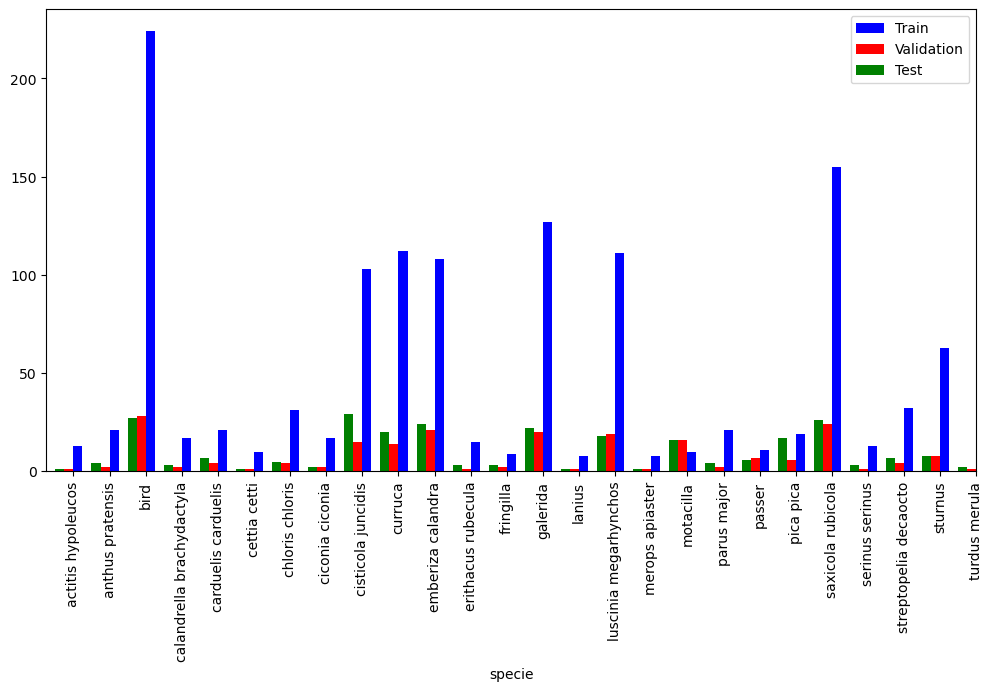

In [41]:
# Count number of instances per specie in each set
train_counts = train_df.groupby('specie').size()
val_counts = validation_df.groupby('specie').size()
test_counts = test_df.groupby('specie').size()


# Plot in WIDTHER bar chart
import matplotlib.pyplot as plt

# Set figure size
fig, ax = plt.subplots(figsize=(12, 6))  # Ajusta el tamaño de la figura aquí (ancho x alto)
train_counts.plot(kind='bar', ax=ax, color='b', position=0, width=0.25)
val_counts.plot(kind='bar', ax=ax, color='r', position=1, width=0.25)
test_counts.plot(kind='bar', ax=ax, color='g', position=2, width=0.25)

# Add legend
ax.legend(['Train', 'Validation', 'Test'])

plt.show()

In [42]:
# Iterate over species groups
for species, group_df in grouped_by_species:
    # Print count of annotations of current species
    specie_count = group_df.shape[0]

    # Calculate the expected counts for the current species based on ratios
    expected_train_count = int(specie_count * train_ratio)
    expected_val_count = int(specie_count * val_ratio)
    expected_test_count = int(specie_count * test_ratio)

    # Calculate the allowed error margin
    error_margin = 0.25

    # Calculate the acceptable range for each set count, rounding up
    min_train_count = int(expected_train_count * (1 - error_margin))
    max_train_count = int(expected_train_count * (1 + error_margin))

    min_val_count = int(expected_val_count * (1 - error_margin))
    max_val_count = int(expected_val_count * (1 + error_margin))

    min_test_count = int(expected_test_count * (1 - error_margin))
    max_test_count = int(expected_test_count * (1 + error_margin))

    if max_test_count <= 2: max_test_count += 2
    if max_val_count <= 2: max_val_count += 2

    # Calculate the actual counts for the current species in each set
    actual_train_count = len(train_df[train_df['specie'] == species])
    actual_val_count = len(validation_df[validation_df['specie'] == species])
    actual_test_count = len(test_df[test_df['specie'] == species])

    # Check if the actual counts fall within the acceptable range, if at more than 2 are out of range, print the species
    out_of_range = 0
    if not (min_train_count <= actual_train_count <= max_train_count):
        out_of_range += 1
    if not (min_val_count <= actual_val_count <= max_val_count):
        out_of_range += 1
    if not (min_test_count <= actual_test_count <= max_test_count):
        out_of_range += 1

    if out_of_range > 1:
        print(f"Species: {species}")
        print(f"Train count: {actual_train_count}, Expected range: [{min_train_count}, {max_train_count}]")
        print(f"Validation count: {actual_val_count}, Expected range: [{min_val_count}, {max_val_count}]")
        print(f"Test count: {actual_test_count}, Expected range: [{min_test_count}, {max_test_count}]")
        print("\n")

Species: carduelis carduelis
Train count: 21, Expected range: [18, 31]
Validation count: 4, Expected range: [2, 3]
Test count: 7, Expected range: [2, 3]


Species: emberiza calandra
Train count: 108, Expected range: [91, 152]
Validation count: 21, Expected range: [11, 18]
Test count: 24, Expected range: [11, 18]


Species: luscinia megarhynchos
Train count: 111, Expected range: [88, 147]
Validation count: 19, Expected range: [10, 17]
Test count: 18, Expected range: [10, 17]


Species: motacilla
Train count: 10, Expected range: [24, 41]
Validation count: 16, Expected range: [3, 5]
Test count: 16, Expected range: [3, 5]


Species: passer
Train count: 11, Expected range: [14, 23]
Validation count: 7, Expected range: [1, 4]
Test count: 6, Expected range: [1, 4]


Species: pica pica
Train count: 19, Expected range: [24, 41]
Validation count: 6, Expected range: [3, 5]
Test count: 17, Expected range: [3, 5]




In [45]:
# Save train df, val df and test df to csv
train_df.to_csv("../Data/Dataset/train_file.csv", index=False)
validation_df.to_csv("../Data/Dataset/validation_file.csv", index=False)
test_df.to_csv("../Data/Dataset/test_file.csv", index=False)

In [48]:
# Read new csvs
train_df = pd.read_csv("../Data/Dataset/train_file.csv")
validation_df = pd.read_csv("../Data/Dataset/validation_file.csv")
test_df = pd.read_csv("../Data/Dataset/test_file.csv")

In [49]:
# Ensure instances from train_df are not in validation df or test df
assert len(train_df.merge(validation_df)) == 0
assert len(train_df.merge(test_df)) == 0
assert len(validation_df.merge(test_df)) == 0

if len(train_df) + len(validation_df) + len(test_df) != len(df):
    # Concatenate train, validation, and test DataFrames
    combined_df = pd.concat([train_df, validation_df, test_df])

    # Drop duplicates to ensure uniqueness
    combined_df = combined_df.drop_duplicates()

    # Merge original DataFrame with combined DataFrame to find rows not present in train, validation, or test sets
    rows_not_in_sets = df.merge(combined_df, how='left', indicator=True)
    rows_not_in_sets = rows_not_in_sets[rows_not_in_sets['_merge'] == 'left_only']

    # Print rows not present in train, validation, or test sets
    print("Rows not present in train, validation, or test sets:")
    print(rows_not_in_sets)

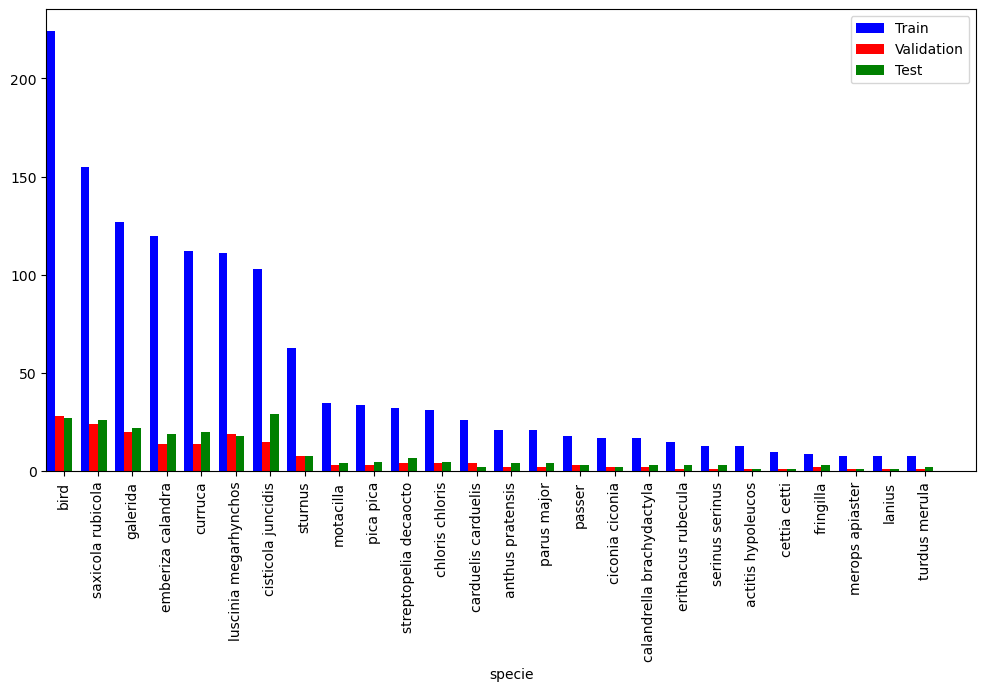

In [54]:
# Count number of instances per specie in each set
train_counts = train_df.groupby('specie').size()
val_counts = validation_df.groupby('specie').size()
test_counts = test_df.groupby('specie').size()

# Plot in WIDTHER bar chart
import matplotlib.pyplot as plt

# Order by train number of instances
train_counts = train_counts.sort_values(ascending=False)
val_counts = val_counts[train_counts.index]
test_counts = test_counts[train_counts.index]

# Set figure size
fig, ax = plt.subplots(figsize=(12, 6))  # Ajusta el tamaño de la figura aquí (ancho x alto)
train_counts.plot(kind='bar', ax=ax, color='b', position=2, width=0.25)
val_counts.plot(kind='bar', ax=ax, color='r', position=1, width=0.25)
test_counts.plot(kind='bar', ax=ax, color='g', position=0, width=0.25)

# Ajusta el límite del eje x para que todas las barras sean visibles
ax.set_xlim(-0.5, len(train_counts) + 0.5)

# Add legend
ax.legend(['Train', 'Validation', 'Test'])

plt.show()

In [56]:
# Iterate over species groups
for species, group_df in grouped_by_species:
    # Print count of annotations of current species
    specie_count = group_df.shape[0]

    # Calculate the expected counts for the current species based on ratios
    expected_train_count = int(specie_count * train_ratio)
    expected_val_count = int(specie_count * val_ratio)
    expected_test_count = int(specie_count * test_ratio)

    # Calculate the allowed error margin
    error_margin = 0.25

    # Calculate the acceptable range for each set count, rounding up
    min_train_count = int(expected_train_count * (1 - error_margin))
    max_train_count = int(expected_train_count * (1 + error_margin))

    min_val_count = int(expected_val_count * (1 - error_margin))
    max_val_count = int(expected_val_count * (1 + error_margin))

    min_test_count = int(expected_test_count * (1 - error_margin))
    max_test_count = int(expected_test_count * (1 + error_margin))

    if max_test_count <= 2: max_test_count += 2
    if max_val_count <= 2: max_val_count += 2

    # Calculate the actual counts for the current species in each set
    actual_train_count = len(train_df[train_df['specie'] == species])
    actual_val_count = len(validation_df[validation_df['specie'] == species])
    actual_test_count = len(test_df[test_df['specie'] == species])

    # Check if the actual counts fall within the acceptable range, if at more than 2 are out of range, print the species
    out_of_range = 0
    if not (min_train_count <= actual_train_count <= max_train_count):
        out_of_range += 1
    if not (min_val_count <= actual_val_count <= max_val_count):
        out_of_range += 1
    if not (min_test_count <= actual_test_count <= max_test_count):
        out_of_range += 1

    if out_of_range > 1:
        print(f"Species: {species}")
        print(f"Train count: {actual_train_count}, Expected range: [{min_train_count}, {max_train_count}]")
        print(f"Validation count: {actual_val_count}, Expected range: [{min_val_count}, {max_val_count}]")
        print(f"Test count: {actual_test_count}, Expected range: [{min_test_count}, {max_test_count}]")
        print("\n")

Species: luscinia megarhynchos
Train count: 111, Expected range: [88, 147]
Validation count: 19, Expected range: [10, 17]
Test count: 18, Expected range: [10, 17]




In [57]:
# Save train df, val df and test df to definitive csv locations
train_df.to_csv(train_file, index=False)
validation_df.to_csv(validation_file, index=False)
test_df.to_csv(test_file, index=False)